# Greedy Layer-Wise Pretraining in Deep Learning Neural Networks

https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/

## Goal

Try to solve the **vanishing gradient problem**: As the number of hidden layers is increased, the amount of error information propagated back to earlier layers is dramatically reduced. This means that weights in hidden layers close to the output layer are updated normally, whereas weights in hidden layers close to the input layer are updated minimally or not at all. 



### Example Multi-class Classification Problem

The problem will be configured with two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. 

**we want the classes to be non-linearly separable so that the problem is non-trivial**

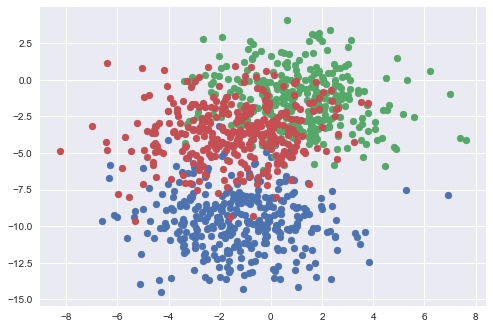

In [1]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
	# select indices of points with the class label
	row_ix = np.where(y == class_value)
	# scatter plot for points with a different color
	plt.scatter(X[row_ix, 0], X[row_ix, 1])

## Supervised Greedy Layer-Wise Pretraining

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = keras.utils.to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

In [4]:
# prepare data
trainX, testX, trainy, testy = prepare_data()

In [5]:
def get_base_model(trainX, trainy):
    # define model 
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    # complie the model 
    optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # fit model with default batch size of 32 examples
    model.fit(trainX, trainy, epochs=100, verbose=0) # verbose=0 no output msg
    return model

In [6]:
model = get_base_model(trainX, trainy)

In [7]:
# evaluate a fit model
def evaluate_model(model, trainX, testX, trainy, testy):
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	return train_acc, test_acc

In [8]:
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
print(f'> layers={len(model.layers):d}, train_acc={train_acc:.3f}, test_acc={test_acc:.3f}')

> layers=2, train_acc=0.808, test_acc=0.822


In [9]:
# add ONE new layer and re-train only the new layer
def add_layer(model, trainX, trainy):
    # remember the current output layer
    output_layer = model.layers[-1]
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable =False
    # add a hidden layer
    model.add(keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform'))
    # add the output layer back
    model.add(output_layer)
    # fit the updated model
    model.fit(trainX, trainy, epochs=100, verbose=0)

In this case, we will add 10 layers, one at a time, and evaluate the performance of the model after each additional layer is added to get an idea of how it is impacting performance.

Train and test accuracy scores are stored in the dictionary against the number of layers in the model.

In [10]:
# add layers and evaluate the updated model per new layer
n_layers = 10
for i in range(n_layers):
	# add layer
	add_layer(model, trainX, trainy)
	# evaluate model
	train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
	print(f'> layers={len(model.layers):d}, train_acc={train_acc:.3f}, test_acc={test_acc:.3f}')
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)

> layers=3, train_acc=0.832, test_acc=0.822
> layers=4, train_acc=0.824, test_acc=0.818
> layers=5, train_acc=0.836, test_acc=0.818
> layers=6, train_acc=0.850, test_acc=0.822
> layers=7, train_acc=0.832, test_acc=0.816
> layers=8, train_acc=0.842, test_acc=0.822
> layers=9, train_acc=0.836, test_acc=0.822
> layers=10, train_acc=0.818, test_acc=0.824
> layers=11, train_acc=0.820, test_acc=0.828
> layers=12, train_acc=0.836, test_acc=0.822


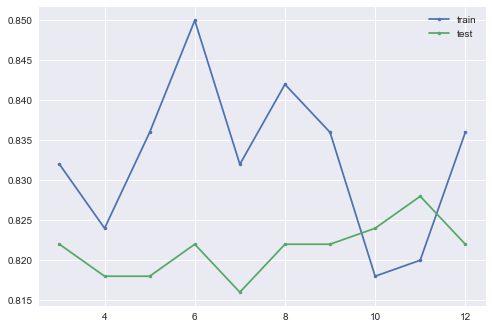

In [11]:
# plot number of added layers vs accuracy
plt.plot(list(scores.keys()), [scores[k][0] for k in scores.keys()], label='train', marker='.')
plt.plot(list(scores.keys()), [scores[k][1] for k in scores.keys()], label='test', marker='.')
plt.legend()

We expect that the addition of layers should improve the model performance but the plot may not support that (if you see higher training accuracy with lower testing accuracy - an indicator for overfitting). 

Additional things to try:
- run a few times and choose a good model (due to the randomness)
- more layers
- smaller learning rate
- more training epochs

## Unsupervised Greedy Layer-Wise Pretraining

We will develop an autoencoder model that will be trained to reconstruct input data. In order to use this unsupervised model for classification, we will remove the output layer, add and fit a new output layer for classification.

The first step is to define, fit, and evaluate an autoencoder model. We will use the same two-layer base model as we did in the previous section, except modify it to predict the input as the output and use mean squared error to evaluate how good the model is at reconstructing a given input sample.

The first step is to define, fit, and evaluate an autoencoder model. We will use the same two-layer base model as we did in the previous section, except modify it to predict the input as the output and use mean squared error to evaluate how good the model is at reconstructing a given input sample.

In [28]:
# define, fit, and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
    # define the model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(2, activation='linear'))
    # compile the model
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9))
    # fit the model, note that the test set is also the train set here
    model.fit(trainX, trainX, epochs=100, verbose=0)
    # evaluate reconstruction loss
    train_mse = model.evaluate(trainX, trainX, verbose=0)
    test_mse = model.evaluate(testX, testX, verbose=0)
    print(f'> reconstruction error train_mse={train_mse:.3f}, test_mse={test_mse:.3f}')
    return model

In [29]:
# get the base autoencoder
model = base_autoencoder(trainX, testX)

> reconstruction error train_mse=0.000, test_mse=0.000


In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 22        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [31]:
# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
    # remember the current output layer
    output_layer = model.layers[-1]
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # add new output layer
    model.add(keras.layers.Dense(3, activation='softmax'))
    # compile model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9), 
        metrics=['accuracy'])
    # fit the model to try the last classification layer
    # should not use trianX??? should be new labeled data??
    model.fit(trainX, trainy, epochs=100, verbose=0)
    # evaluate model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    # put the autoencoder model back
    model.pop()
    model.add(output_layer)
    model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9))
    return train_acc, test_acc

In [32]:
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
print(f'> classifier accuracy layers={len(model.layers):d}, train_acc={train_acc:.3f}, test_acc={test_acc:.3f}')

> classifier accuracy layers=2, train_acc=0.828, test_acc=0.830


In [33]:
# evaluate the base model
scores = {}
scores[len(model.layers)] = (train_acc, test_acc)
scores

{2: (0.828000009059906, 0.8299999833106995)}

In [34]:
def add_layer_to_autoencoder(model, trainX, testX):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(keras.layers.Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print(f'> reconstruction error train_mse={train_mse:.3f}, test_mse={test_mse:.3f}')

In [35]:
n_layers = 5
for _ in range(n_layers):
	# add layer
	add_layer_to_autoencoder(model, trainX, testX)
	# evaluate model
	train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
	print(f'> classifier accuracy layers={len(model.layers):d}, train_acc={train_acc:.3f}, test_acc={test_acc:.3f}')
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)

> reconstruction error train_mse=0.003, test_mse=0.004
> classifier accuracy layers=3, train_acc=0.838, test_acc=0.826
> reconstruction error train_mse=0.018, test_mse=0.024
> classifier accuracy layers=4, train_acc=0.812, test_acc=0.832
> reconstruction error train_mse=10.411, test_mse=10.656
> classifier accuracy layers=5, train_acc=0.342, test_acc=0.326
> reconstruction error train_mse=10.409, test_mse=10.678
> classifier accuracy layers=6, train_acc=0.342, test_acc=0.326
> reconstruction error train_mse=10.412, test_mse=10.682
> classifier accuracy layers=7, train_acc=0.334, test_acc=0.332


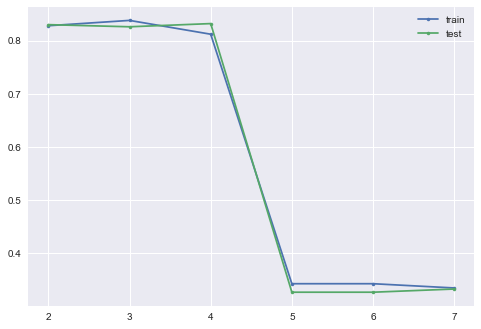

In [36]:
# plot number of added layers vs accuracy
keys = list(scores.keys())
plt.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
plt.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
plt.legend()

The plot does not show any benefits of the unsupervised pre-training.